In [0]:
from __future__ import division
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np
from moviepy.editor import VideoFileClip
cwd = os.getcwd()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This notebook is freely inspired by Priyanka Dwivedi's work on parking spot detector: https://github.com/priya-dwivedi/Deep-Learning/tree/master/parking_spots_detector

Some functions are copied from her notebook, other have been re-made differently.

I tested an incredible amount of parameters and reimplementation for the functions of canny edge and probabilistic hough lines, but I found that Priyanka already did this job and chose almost the best parameters. So even if I did all the research, my results and choice of parameters are close to her's, but yet different.

In [0]:
# function made by Priyanka Dwivedi

def afficher_images(images,cmap=None):
  plt.figure(figsize=(15,12))
  n=len(images)
  for i in range(n):
    plt.subplot((n+1)//2,2,i+1)
    cmap = 'gray' if len(images[i].shape)==2 else cmap
    plt.imshow(images[i],cmap=cmap)
    plt.xticks([])
    plt.yticks([])
  plt.tight_layout(pad=0,h_pad=0,w_pad=0)
  plt.show

In [0]:
test_images = [plt.imread(path) for path in glob.glob('/content/gdrive/My Drive/Colab Notebooks/test_images/*.jpg')]

#afficher_images(test_images)

images in white and yellow
images in grey, usable for canny edge


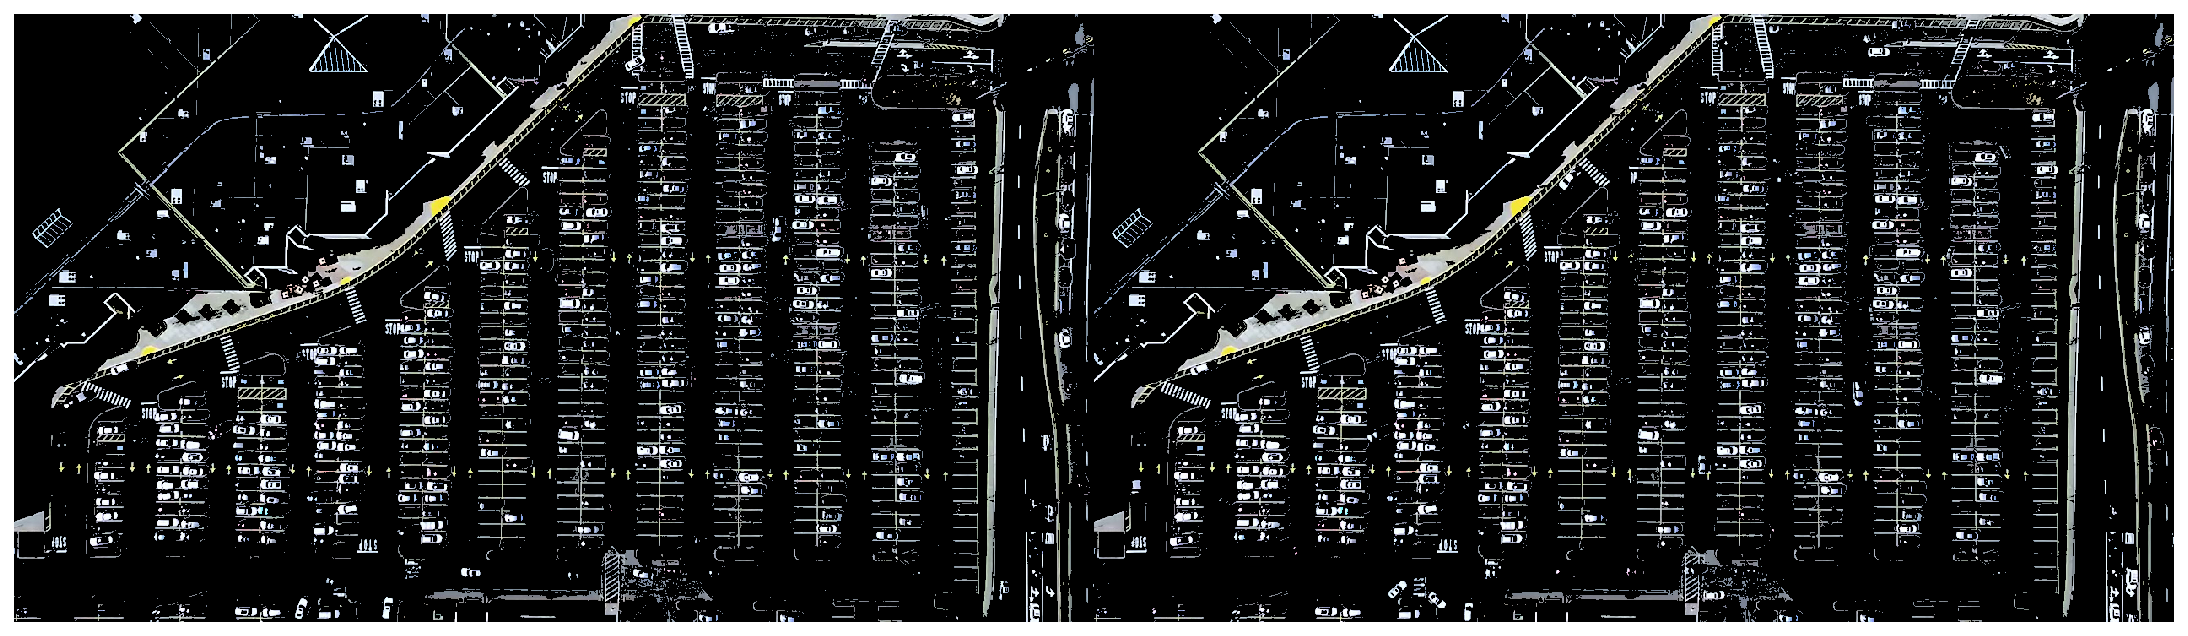

In [0]:
# code inspired from : https://stackoverflow.com/questions/50221851/cant-make-yellow-disappear-with-hsv-opencv-python

HSV_RANGES = {
    'yellow': [
        {
            'lower': np.array([190, 190, 0]),
            'upper': np.array([255, 255, 255])
        }
    ],
    'white': [
        {
            'lower': np.array([120, 120, 120]),
            'upper': np.array([255, 255, 255])
        }
    ]
}


def create_masked_img(hsv_img):
    """
    Creates a binary mask from HSV image using given colors.
    """
    mask = np.zeros((hsv_img.shape[0], hsv_img.shape[1]), dtype=np.uint8)
  
    
    for color in ['yellow','white']:
        for color_range in HSV_RANGES[color]:
            mask += cv2.inRange(
                hsv_img,
                color_range['lower'],
                color_range['upper']
            )

    masked = cv2.bitwise_and(hsv_img, hsv_img, mask = mask)
    return masked
  
# image in RGB masked yellow & white
images_jb = []
for i in test_images:
  images_jb.append(create_masked_img(i))
print("images in white and yellow") 
afficher_images(images_jb) 

# images in grey, useful for canny edge
print("images in grey, usable for canny edge")
images_gray = []
for i in images_jb:
  images_gray.append(cv2.cvtColor(i, cv2.COLOR_RGB2GRAY))

#afficher_images(images_gray)

In [0]:
# the cannied images
print("canny edged images")
canny_images = []
for i in images_gray:
  canny_images.append(cv2.Canny(i,50,180))

#afficher_images(canny_images)

canny edged images


In [0]:
# function inspired by Priyanka Dwivedi - not the same

def highlight_parking(image):
    #we keep only the parking in the image and delete the sourrounding of it
    
    # first, we define the polygone (by its vertices) that exactly sourround the parking lot
    rows, cols = image.shape[:2]
    pt_1 = [cols*0.05, rows*0.90]
    pt_2 = [cols*0.05, rows*0.70]
    pt_3 = [cols*0.30, rows*0.55]
    pt_4 = [cols*0.6, rows*0.15]
    pt_5 = [cols*0.90, rows*0.15] 
    pt_6 = [cols*0.90, rows*0.90]
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[pt_1, pt_2, pt_3, pt_4, pt_5, pt_6]], dtype=np.int32)
    
    # create and apply the mask that will delete all the photo except the useful part, ie the parking
    mask = np.zeros_like(image)
    cv2.fillPoly(mask,vertices,255)
    return cv2.bitwise_and(image,mask)


# images showing the region of interest only
useful_images=[]
for i in canny_images:
  useful_images.append(highlight_parking(i))

#afficher_images(useful_images)

In [0]:
hough_lines = []
for i in useful_images:
  hough_lines.append(cv2.HoughLinesP(i, rho=0.1, theta=np.pi/10, threshold=15, minLineLength=9, maxLineGap=4))

def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    cleaned = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(y2-y1) <=1 and abs(x2-x1) >=25 and abs(x2-x1) <= 55:
                cleaned.append((x1,y1,x2,y2))
                cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    print(" No lines detected: ", len(cleaned))
    return image


line_images = []
for image, lines in zip(test_images, hough_lines):
    line_images.append(draw_lines(image, lines))
    
#afficher_images(line_images)

 No lines detected:  585
 No lines detected:  553


In [0]:
#from skimage.transform import (hough_line, hough_line_peaks,
#                               probabilistic_hough_line)

#hough_lines_list = []
#for i in useful_images:
#  hough_lines_list.append(probabilistic_hough_line(i, threshold=20, line_length=10,
#                                 line_gap=20))
#  
#print(len(hough_lines_list))
#
#def draw_lines(image, lines, color=[0, 0, 255], thickness=2, make_copy=True):
#    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
#    if make_copy:
#        image = np.copy(image) # don't want to modify the original
#    cleaned = []
#    for p1,p2 in lines:
#        #print(line)
#        #for p1,p2 in line:
#        x1,y1,x2,y2=p1[0],p1[1],p2[0],p2[1]
#        if abs(y2-y1) <=1 and abs(x2-x1) >=25 and abs(x2-x1) <= 55:
#          cleaned.append((x1,y1,x2,y2))
#          cv2.line(image, (x1, y1), (x2, y2), color, thickness)
#    print(" No lines detected: ", len(cleaned))
#    return image
#
#
#line_images = []
#for image, lines in zip(test_images, hough_lines_list):
#    line_images.append(draw_lines(image, lines))
#    
#afficher_images(line_images)

In [0]:
# function made by Priyanka Dwivedi to identify the rectengular blocks of parking

def identify_blocks(image, lines, make_copy=True):
    if make_copy:
        new_image = np.copy(image)
    #Step 1: Create a clean list of lines
    cleaned = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(y2-y1) <=1 and abs(x2-x1) >=25 and abs(x2-x1) <= 55:
                cleaned.append((x1,y1,x2,y2))
    
    #Step 2: Sort cleaned by x1 position
    import operator
    list1 = sorted(cleaned, key=operator.itemgetter(0, 1))
    
    #Step 3: Find clusters of x1 close together - clust_dist apart
    clusters = {}
    dIndex = 0
    clus_dist = 10

    for i in range(len(list1) - 1):
        distance = abs(list1[i+1][0] - list1[i][0])
    #         print(distance)
        if distance <= clus_dist:
            if not dIndex in clusters.keys(): clusters[dIndex] = []
            clusters[dIndex].append(list1[i])
            clusters[dIndex].append(list1[i + 1])

        else:
            dIndex += 1
    
    #Step 4: Identify coordinates of rectangle around this cluster
    rects = {}
    i = 0
    for key in clusters:
        all_list = clusters[key]
        cleaned = list(set(all_list))
        if len(cleaned) > 5:
            cleaned = sorted(cleaned, key=lambda tup: tup[1])
            avg_y1 = cleaned[0][1]
            avg_y2 = cleaned[-1][1]
    #         print(avg_y1, avg_y2)
            avg_x1 = 0
            avg_x2 = 0
            for tup in cleaned:
                avg_x1 += tup[0]
                avg_x2 += tup[2]
            avg_x1 = avg_x1/len(cleaned)
            avg_x2 = avg_x2/len(cleaned)
            rects[i] = (avg_x1, avg_y1, avg_x2, avg_y2)
            i += 1
    
    print("Num Parking Lanes: ", len(rects))
    #Step 5: Draw the rectangles on the image
    buff = 7
    for key in rects:
        tup_topLeft = (int(rects[key][0] - buff), int(rects[key][1]))
        tup_botRight = (int(rects[key][2] + buff), int(rects[key][3]))
#         print(tup_topLeft, tup_botRight)
        cv2.rectangle(new_image, tup_topLeft,tup_botRight,(0,255,0),3)
    return new_image, rects

# images showing the region of interest only
rect_images = []
rect_coords = []
for image, lines in zip(test_images, hough_lines):
    new_image, rects = identify_blocks(image, lines)
    rect_images.append(new_image)
    rect_coords.append(rects)
    
#afficher_images(rect_images)

Num Parking Lanes:  12
Num Parking Lanes:  12


In [0]:
# function made by Priyanka Dwivedi to identify each spot and count the number of parking space
# it then print an image with a vizualization of all parking spaces

def draw_parking(image, rects, make_copy = True, color=[255, 0, 0], thickness=2, save = True):
    if make_copy:
        new_image = np.copy(image)
    gap = 15.5
    spot_dict = {} # maps each parking ID to its coords
    tot_spots = 0
    adj_y1 = {0: 20, 1:-10, 2:0, 3:-11, 4:28, 5:5, 6:-15, 7:-15, 8:-10, 9:-30, 10:9, 11:-32}
    adj_y2 = {0: 30, 1: 50, 2:15, 3:10, 4:-15, 5:15, 6:15, 7:-20, 8:15, 9:15, 10:0, 11:30}
    
    adj_x1 = {0: -8, 1:-15, 2:-15, 3:-15, 4:-15, 5:-15, 6:-15, 7:-15, 8:-10, 9:-10, 10:-10, 11:0}
    adj_x2 = {0: 0, 1: 15, 2:15, 3:15, 4:15, 5:15, 6:15, 7:15, 8:10, 9:10, 10:10, 11:0}
    for key in rects:
        # Horizontal lines
        tup = rects[key]
        x1 = int(tup[0]+ adj_x1[key])
        x2 = int(tup[2]+ adj_x2[key])
        y1 = int(tup[1] + adj_y1[key])
        y2 = int(tup[3] + adj_y2[key])
        cv2.rectangle(new_image, (x1, y1),(x2,y2),(0,255,0),2)
        num_splits = int(abs(y2-y1)//gap)
        for i in range(0, num_splits+1):
            y = int(y1 + i*gap)
            cv2.line(new_image, (x1, y), (x2, y), color, thickness)
        if key > 0 and key < len(rects) -1 :        
            #draw vertical lines
            x = int((x1 + x2)/2)
            cv2.line(new_image, (x, y1), (x, y2), color, thickness)
        # Add up spots in this lane
        if key == 0 or key == (len(rects) -1):
            tot_spots += num_splits +1
        else:
            tot_spots += 2*(num_splits +1)
            
        # Dictionary of spot positions
        if key == 0 or key == (len(rects) -1):
            for i in range(0, num_splits+1):
                cur_len = len(spot_dict)
                y = int(y1 + i*gap)
                spot_dict[(x1, y, x2, y+gap)] = cur_len +1        
        else:
            for i in range(0, num_splits+1):
                cur_len = len(spot_dict)
                y = int(y1 + i*gap)
                x = int((x1 + x2)/2)
                spot_dict[(x1, y, x, y+gap)] = cur_len +1
                spot_dict[(x, y, x2, y+gap)] = cur_len +2   
    
    print("total parking spaces: ", tot_spots, cur_len)
    if save:
        filename = 'with_parking.jpg'
        cv2.imwrite(filename, new_image)
    return new_image, spot_dict

delineated = []
spot_pos = []
for image, rects in zip(test_images, rect_coords):
    new_image, spot_dict = draw_parking(image, rects)
    delineated.append(new_image)
    spot_pos.append(spot_dict)
    
#afficher_images(delineated)

total parking spaces:  540 539
total parking spaces:  555 554


In [0]:
# here I chose the one who matches the more the reality

#final_spot_dict = spot_pos[1]
final_spot_dict = spot_pos[0]

In [0]:
#print(len(final_spot_dict))

In [0]:
def assign_spots_map(image, spot_dict=final_spot_dict, make_copy = True, color=[255, 0, 0], thickness=2):
    if make_copy:
        new_image = np.copy(image)
    for spot in spot_dict.keys():
        (x1, y1, x2, y2) = spot
        cv2.rectangle(new_image, (int(x1),int(y1)), (int(x2),int(y2)), color, thickness)
    return new_image

marked_spot_images = list(map(assign_spots_map, test_images))
#afficher_images(marked_spot_images)

In [0]:
### Save spot dictionary as pickle file
import pickle

with open('spot_dict.pickle', 'wb') as handle:
    pickle.dump(final_spot_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
def save_images_for_cnn(image, spot_dict = final_spot_dict, folder_name ='for_cnn'):
    for spot in spot_dict.keys():
        (x1, y1, x2, y2) = spot
        (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
        #crop this image
#         print(image.shape)
        spot_img = image[y1:y2, x1:x2]
        spot_img = cv2.resize(spot_img, (0,0), fx=2.0, fy=2.0) 
        spot_id = spot_dict[spot]
        
        filename = 'spot' + str(spot_id) +'.jpg'
        print(spot_img.shape, filename, (x1,x2,y1,y2))
        
        cv2.imwrite(os.path.join(folder_name, filename), spot_img)
        
# save_images_for_cnn(test_images[0])

### Use a pre-trained CNN to make predictions

Started from here it's exclusively my work, as my CNN is not the same as Priyanka Dwivedi's.


In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() 

In [0]:
from PIL import Image
model = torch.load("/content/gdrive/My Drive/Colab Notebooks/vgg16bn/vgg16_bn_2.pth")
#model = torch.load("vgg16bn/vgg16_bn_2.pth",map_location='cpu')
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:


def find_class(image):
    # Convert to a 4D tensor
    image = torchvision.transforms.functional.to_pil_image(image)

    # Resize the image
    operation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x),])
    image = operation(image)        
    image = torch.from_numpy(np.expand_dims(image, axis=0))
    
    # check if we're on CPU or GPU
    if torch.cuda.is_available():
          image = Variable(image.cuda(), volatile=True)
    else:
          image = Variable(image, volatile=True)
        
    # use the CNN to obtain the predicted class: 'empy' or 'occupied'
    outputs = model(image)
    _, class_predicted = torch.max(outputs.data, 1)
    cpu_pred=class_predicted.cpu()
    label = cpu_pred.numpy()[0]
    if label==1:
        return 'occupied'
    else:
        return 'empty'

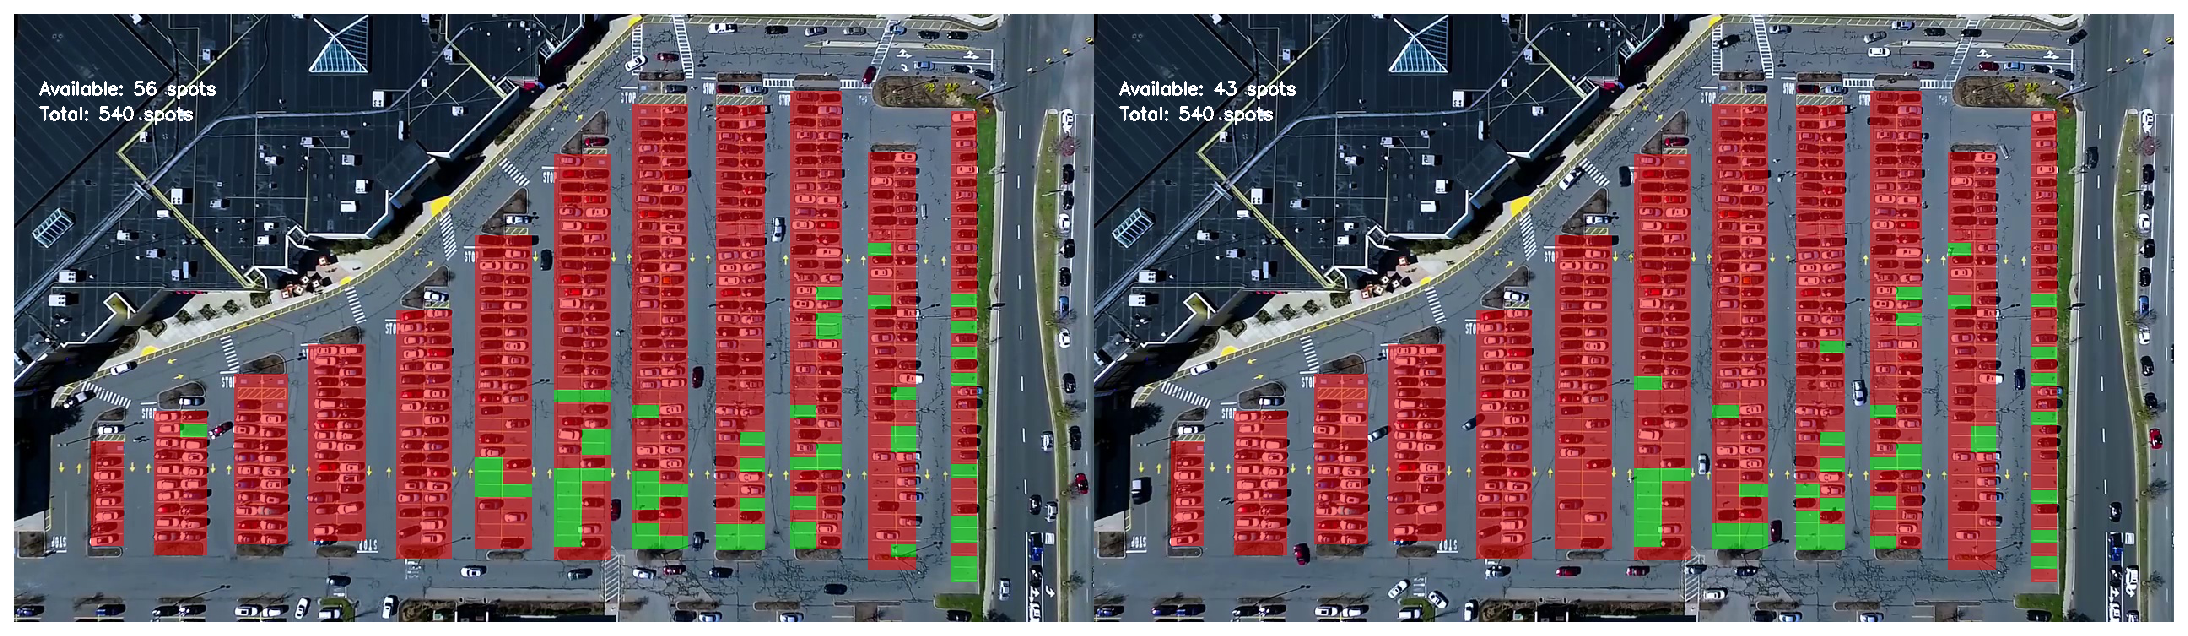

In [0]:
def obtain_parking_map(image, spot_dict = final_spot_dict, make_copy=True, alpha=0.5):
    if make_copy:
        new_image = np.copy(image)
        overlay = np.copy(image)
    
    empty_spots, total_spots = 0, 0

    for spot in spot_dict.keys():
        total_spots += 1
        
        #select only one spot
        (x1, y1, x2, y2) = spot
        (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
        spot_img = image[y1:y2, x1:x2]        
        
        # use find_class to predict the state of the spot and color it in green if 'empty'
        label = find_class(spot_img)
        if label == 'empty':
            cv2.rectangle(overlay, (int(x1),int(y1)), (int(x2),int(y2)), [0, 255, 0], -1)
            empty_spots += 1
        else:
            cv2.rectangle(overlay, (int(x1),int(y1)), (int(x2),int(y2)), [255, 0, 0], -1)
            
    cv2.addWeighted(overlay, alpha, new_image, 1 - alpha, 0, new_image)
            
    cv2.putText(new_image, "Available: %d spots" %empty_spots, (30, 95),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (255, 255, 255), 2)
    
    cv2.putText(new_image, "Total: %d spots" %total_spots, (30, 125),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (255, 255, 255), 2)
    save = False
    
    if save:
        filename = 'with_marking.jpg'
        cv2.imwrite(filename, new_image)
    return new_image


predicted_images = []
for i in test_images:
  predicted_images.append(obtain_parking_map(i))

afficher_images(predicted_images)

### Run code on video

In [0]:
def highlight_parking(image):
    #we keep only the parking in the image and delete the sourrounding of it
    
    # first, we define the polygone (by its vertices) that exactly sourround the parking lot
    rows, cols = image.shape[:2]
    pt_1 = [cols*0.05, rows*0.90]
    pt_2 = [cols*0.05, rows*0.70]
    pt_3 = [cols*0.30, rows*0.55]
    pt_4 = [cols*0.6, rows*0.15]
    pt_5 = [cols*0.90, rows*0.15] 
    pt_6 = [cols*0.90, rows*0.90]
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[pt_1, pt_2, pt_3, pt_4, pt_5, pt_6]], dtype=np.int32)
    
    # create and apply the mask that will delete all the photo except the useful part, ie the parking
    mask = np.zeros_like(image)
    cv2.fillPoly(mask,vertices,255)
    return cv2.bitwise_and(image,mask)

def obtain_parking_spots():
    test_images = [plt.imread(path) for path in glob.glob('/content/gdrive/My Drive/Colab Notebooks/test_images/*.jpg')]
    images_jb = []
    for i in test_images:
        images_jb.append(create_masked_img(i))
    images_gray = []
    for i in images_jb:
        images_gray.append(cv2.cvtColor(i, cv2.COLOR_RGB2GRAY))
    canny_images = []
    for i in images_gray:
        canny_images.append(cv2.Canny(i,50,180))
    useful_images=[]
    for i in canny_images:
        useful_images.append(highlight_parking(i))
    hough_lines = []
    for i in useful_images:
        hough_lines.append(cv2.HoughLinesP(i, rho=0.1, theta=np.pi/10, threshold=15, minLineLength=9, maxLineGap=4))
    
       

I finally realized I don't need to compute the parking spots again after the first time: the movements of the drone are little enough to be a real problem.

I just used openCV the decompose the video into images and then treat every images, stick all of it together and obtain a treated video.

For a weird reason it doesn't work on google colab.


In [1]:
videofile = '/content/gdrive/My Drive/Colab Notebooks/parking_video.mp4'
cap = cv2.VideoCapture(videofile)

model = torch.load("/content/gdrive/My Drive/Colab Notebooks/vgg16bn/vgg16_bn_2.pth")
model.eval()


while(True):

    ret,frame = cap.read()
    if(ret == False):
        print("Done")
        break

    image = obtain_parking_map(image, spot_dict = final_spot_dict, make_copy=True, alpha=0.5)

    print("lol")
    cv2.imshow('frame',image)
    print("lol")
    #QUIT
    if(cv2.waitKey(10) & 0xFF == ord('q')):
        cv2.destroyWindow("video")
        break

cap.release()
cv2.destroyAllWindows()


NameError: ignored

In [0]:
video_name = '/content/gdrive/My Drive/Colab Notebooks/parking_video.mp4'
cap = cv2.VideoCapture(video_name)
count = 0

while True:
        ret, image = cap.read()
        if(ret == False):
          print("Done")
          break
        count += 1
        if count == 5:
            count = 0
            
            new_image = np.copy(image)
            overlay = np.copy(image)
            cnt_empty = 0
            all_spots = 0
            color = [0, 255, 0] 
            alpha=0.5
            for spot in final_spot_dict.keys():
                all_spots += 1
                (x1, y1, x2, y2) = spot
                (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
                #crop this image
                spot_img = image[y1:y2, x1:x2]
                spot_img = cv2.resize(spot_img, (48, 48)) 

                label = find_class(spot_img)
        #         print(label)
                if label == 'empty':
                    cv2.rectangle(overlay, (int(x1),int(y1)), (int(x2),int(y2)), color, -1)
                    cnt_empty += 1
                else:
                    cv2.rectangle(overlay, (int(x1),int(y1)), (int(x2),int(y2)), [255, 0, 0], -1)

            cv2.addWeighted(overlay, alpha, new_image, 1 - alpha, 0, new_image)

            cv2.putText(new_image, "Available: %d spots" %cnt_empty, (30, 95),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 255, 255), 2)

            cv2.putText(new_image, "Total: %d spots" %all_spots, (30, 125),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 255, 255), 2)
            cv2.imshow('frame', new_image)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        #out.write(image)

cv2.destroyAllWindows()
cap.release()